# Задача 2

## Постановка задачи
---
В пункте В2 сталь поступает на условный производственный комплекс, состоящий из сталелитейного и станкостроительного заводов. Он функционирует в течение 5 лет.

Начальный запас стали составляет __3100__ т (для решения; интервал для исследования — 1000–10000 т (\*)).
Исходные производственные мощности заводов соответственно:
- по стали — __4300__ т в год;
- по станкам — __1300__ станков в год (для решения; интервал для исследования — 100–5000 станков). (\*\*)

Сталь расходуется на производство станков (__1.1__ т на каждый) и собственно стали, а также на расширение производственных мощностей комплекса. При этом каждая тонна стали, направленная на ее производство, обеспечивает выпуск __3.4__ т. Тонна стали, идущая на расширение производственной мощности сталелитейного завода, увеличивает последнюю на __0.1__ т, а для увеличения производственных мощностей станкостроительного завода на один станок необходимо затратить __15__ т стали. Реализация решения о распределении стали на следующий год осуществляется в конце очередного года планируемого периода; станкостроительный завод не может получать более половины имеющегося запаса стали.

Требуется:
1. определить план распределения стали между сталелитейным и станкостроительным заводами, обеспечивающий выпуск __максимального количества станков__ за плановый период;
1. провести исследование (поочередно, по одному фактору) влияния начальных условий (\*) и (\*\*) на структуру и результат решения (т.е. на распределение стали и на объем выпуска станков).


## Формальная постановка задачи


Пусть $x_{ij}$ - это количество тонн стали, которое будет израсходовано в i-ом году на j-ую потребность в производстве, где  

$x_{i1}$ - производство стали,  
$x_{i2}$ - расширение производства стали,  
$x_{i3}$ - производство станков,  
$x_{i4}$ - расширение производства станков.
#### Целевая функция:
$f(\bar{x})=\sum_{j=1}^{4}x_{ij} \rightarrow max, i = \overline{1,\ 5}$

#### Ограничения:

Сумма затрат стали в году равна количеству в резерве:  
$x_{11}+x_{12}+x_{13}+x_{14}=3100$  
$x_{21}+x_{22}+x_{23}+x_{24}=3.4x_{11}$  
$x_{31}+x_{32}+x_{33}+x_{34}=3.4x_{21}$  
$x_{41}+x_{42}+x_{43}+x_{44}=3.4x_{31}$  
$x_{51}+x_{52}+x_{53}+x_{54}=3.4x_{41}$  

Будет выпущено стали не более чем возможно:  
$3.4x_{11}\le4300$  
$3.4x_{21}\le4300+0.1x_{12}$  
$3.4x_{31}\le4300+0.1(x_{12}+x_{22})$  
$3.4x_{41}\le4300+0.1(x_{12}+x_{22}+x_{32})$  
$3.4x_{51}\le4300+0.1(x_{12}+x_{22}+x_{32}+x_{42})$  

Будет выпущено станков не более чем возможно:  
$\frac{x_{13}}{1.1}\le1300$  
$\frac{x_{23}}{1.1}\le1300+\frac{x_{14}}{15}$  
$\frac{x_{33}}{1.1}\le1300+\frac{x_{14}+x_{24}}{15}$  
$\frac{x_{43}}{1.1}\le1300+\frac{x_{14}+x_{24}+x_{34}}{15}$  
$\frac{x_{53}}{1.1}\le1300+\frac{x_{14}+x_{24}+x_{34}+x_{44}}{15}$  

Cтанкостроительный завод не может получать более половины имеющегося запаса стали:  
$x_{13}+x_{14}\le0.5\times3100$  
$x_{23}+x_{24}\le0.5\times3.4x_{11}$  
$x_{33}+x_{34}\le0.5\times3.4x_{21}$  
$x_{43}+x_{44}\le0.5\times3.4x_{31}$  
$x_{53}+x_{54}\le0.5\times3.4x_{41}$  

И все затраты не могут быть отрицательными  
$x_{ij}\ge0, i = \overline{1,\ 5}, j = \overline{1,\ 4}$

## Решение

### Поиск оптимального плана распределения стали

In [1]:
import numpy
from cvxopt.modeling import variable
from cvxopt.modeling import op
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Для проведения исследований удобнее всего будет поместить сразу решение в один класс. 

In [2]:
# Решатель задачи 2
class Solver:
    def __init__(self):
        self.years = 5 # период
        self.initial_steel_reserve = 3100 # начальный запас стали
        self.production_capacity_steel = 4300 # производственная мощность литейки
        self.production_capacity_machine = 1300 # производственная мощность станков
        
        # производство
        self.steel_cost = 1 # потрачено на сталь
        self.steel_rise = 3.4 # получено стали
        self.machine_cost = 1.1 # потрачено на станок
        self.machine_rise = 1 # получено станков
        
        #pc - production capacity
        # увеличение производственной мощности
        self.steel_pc_cost = 1 # стоимость прироста мощности литейки
        self.steel_pc_rise = 0.1 # получен прирост мощности литейки
        self.machine_pc_cost = 15 # стоимость прироста мощности литейки
        self.machine_pc_rise = 1 # получен прирост мощности литейки
        
    # Для исследования
    def SetInitialSteelReserve(self, n):
        self.initial_steel_reserve = n
        
    # Для исследования
    def SetMachineProductionCapacity(self, n):
        self.production_capacity_machine = n
        
    # Решить
    def Solve(self):
        spent_steel_prod = variable(self.years, 'на произв. стали') # потрачено на производство стали
        spent_steel_inc = variable(self.years, 'на ув.кол. стали') # потрачено на увеличение стали
        spent_machine_prod = variable(self.years, 'на произв. станков') # потрачено на производство станков
        spent_machine_inc = variable(self.years, 'на ув.кол. станков') # потрачено на увеличение станков
        
        # Получить сталь, которая будет выпущена за год (с коэффициентом)
        GetReleasedSteel = lambda year: spent_steel_prod[year] / self.steel_cost * self.steel_rise
        # Получить запас стали на текущий год
        GetCurSteelReserve = lambda year: self.initial_steel_reserve if year == 0 else GetReleasedSteel(year-1)
        # Получить станки, выпущенные за указаный год
        GetReleasedMachines = lambda year: spent_machine_prod[year] / self.machine_cost * self.machine_rise
        # Получить производственную мощь литейки в текущем году
        GetCurSteelProductionCapacity = lambda year: self.production_capacity_steel if year == 0 else self.production_capacity_steel + sum(spent_steel_inc[:year]) / self.steel_pc_cost * self.steel_pc_rise
        # Получить производственную мощь по станкам в текущем году
        GetCurMachinesProductionCapacity = lambda year: self.production_capacity_machine if year == 0 else self.production_capacity_machine + sum(spent_machine_inc[:year]) / self.machine_pc_cost * self.machine_pc_rise
       
        # Сумма затрат стали в году равна количеству в резерве
        d0 = [spent_steel_prod[year] + spent_machine_prod[year] + spent_steel_inc[year] + spent_machine_inc[year] == GetCurSteelReserve(year) for year in range(self.years)]

        # Будет выпущено стали не более чем возможно
        d1 = [GetReleasedSteel(year) <= GetCurSteelProductionCapacity(year) for year in range(self.years)]
        
        # Будет выпущено станков не более чем возможно
        d2 = [GetReleasedMachines(year) <= GetCurMachinesProductionCapacity(year) for year in range(self.years)]
        
        # Cтанкостроительный завод не может получать более половины имеющегося запаса стали
        d3 = [spent_machine_prod[year] + spent_machine_inc[year] <= 0.5 * GetCurSteelReserve(year) for year in range(self.years)]
        
        # И все затраты не могут быть отрицательными
        d4 = [spent_steel_prod[year] >= 0 for year in range(self.years)]
        d5 = [spent_machine_prod[year] >= 0 for year in range(self.years)]
        d6 = [spent_steel_inc[year] >= 0 for year in range(self.years)]
        d7 = [spent_machine_inc[year] >= 0 for year in range(self.years)]
        
        # Решение
        problem = op(-sum(spent_machine_prod/self.machine_cost),
                     d0 + d1 + d2 + d3 + d4 + d5 + d6 + d7)  
        problem.solve(solver = 'glpk')
      
        # Запись ответов
        self.__status = problem.status
        self.__value = -problem.objective.value()[0]
        
        humanize = lambda x: [x.value[i] for i in range(self.years)]
        self.__df =  pd.DataFrame({spent_steel_prod.name: humanize(spent_steel_prod),
                                   spent_machine_prod.name: humanize(spent_machine_prod),
                                   spent_steel_inc.name: humanize(spent_steel_inc),
                                   spent_machine_inc.name: humanize(spent_machine_inc),
                                  })
        
    # Получить статус
    def GetStatus(self):
        return self.__status
    
    # Максимальное количество станков
    def GetObjectiveValue(self):
        return self.__value
    
    # Получить оптимальное решение
    def GetSolution(self):
        return self.__df

In [3]:
solver = Solver()
solver.Solve()
print('Максимальное количество: {}'.format(solver.GetObjectiveValue()))
solver.GetSolution()

Максимальное количество: 6808.533280254261


,на произв. стали,на произв. станков,на ув.кол. стали,на ув.кол. станков
0,1264.705882,1430.000000,285.294118,120.000000
1,1273.096886,1438.800000,876.903114,711.200000
2,1298.888154,1490.954667,865.376552,673.310039
3,934.883062,1540.330736,1273.226800,667.779125
4,1361.788252,1589.301205,227.512953,0.000000


### Анализ с изменением начальных условий

Text(0, 0.5, 'Максимальное количество произведенных станков')

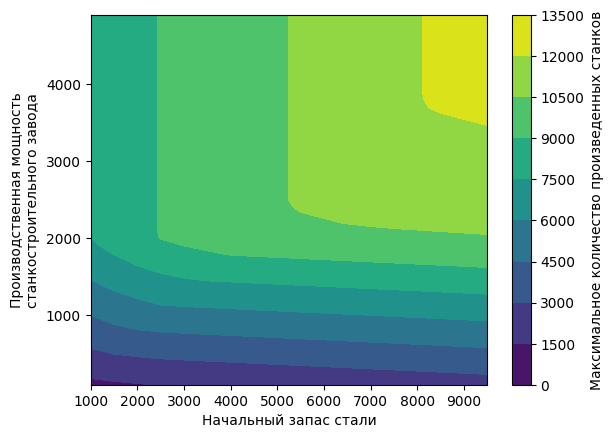

In [4]:
def JustSolve(steel_reserve, machines_per_year):
    solver = Solver()
    solver.SetInitialSteelReserve(float(steel_reserve))
    solver.SetMachineProductionCapacity(float(machines_per_year))
    solver.Solve()
    return solver.GetObjectiveValue()

steel_reserve_vals = np.arange(1000, 10000, 500) # По условию задачи
machines_per_year_vals = np.arange(100, 5000, 100)
xx, yy = np.meshgrid(steel_reserve_vals, machines_per_year_vals)

cs = plt.contourf( steel_reserve_vals, machines_per_year_vals, np.vectorize(JustSolve)(xx,yy) )

plt.xlabel('Начальный запас стали')
plt.ylabel('Производственная мощность\nстанкостроительного завода')

# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('Максимальное количество произведенных станков')